# Thinking model mech interp exploration

In [ ]:
# Configs
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    !pip install -q transformers
    !pip install -q datasets
    !pip install -q huggingface_hub
    !pip install -q sae-lens
    !pip install -q transformer-lens
except:
    IN_COLAB = False
    print("Not running as a Colab notebook. Make sure to have required packages installed")

In [ ]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline # Pipeline needed to create text-generations
from datasets import load_dataset
from huggingface_hub import hf_hub_download, notebook_login

from sae_lens import SAE

import joblib # To offload data or models to disk while not using them

import gc # Garbage collection. E.g. use `gc.collect()`

print("CUDA available:", torch.cuda.is_available())

notebook_login() # Login (Llama 3 8B requires licence agreement access)

## Setups

In [3]:
# Nb requires Hugging Face login
def load_llama_3_8B_model():
    model_name = "meta-llama/Llama-3.1-8B"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    return tokenizer, model

def load_r1_8B_model():
    model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    return tokenizer, model

def load_gsm8k_dataset():
    dataset_name = "openai/gsm8k"
    dataset = load_dataset(dataset_name)
    return dataset

def load_mmlu_dataset(config_name="elementary_mathematics", dataset_size=None):
    dataset_name = "cais/mmlu"
    dataset = load_dataset(dataset_name, config_name)
    return dataset

# Download Llama Scope SAEs for model Llama-3.1-8B
def load_llama_scope_sae(layer_idx, layer_type, sae_dim, device="cpu"):
    if not (0 <= layer_idx <= 31 and isinstance(layer_idx, int)):
        raise ValueError("Invalid layer index. Must be an integer between 0 and 31.")
    if layer_type not in ("a", "m", "r"):
        raise ValueError("Invalid SAE layer type. layer_type must be 'a', 'm', or 'r'.")
    if sae_dim not in (8, 32):
        raise ValueError("Invalid SAE dimension. sae_dim must be 8 or 32.")
    release = "llama_scope_lx{}_{}x".format(layer_type, sae_dim)
    sae_id = "l{}{}_{}x".format(layer_idx, layer_type, sae_dim)
    sae = SAE.from_pretrained(release, sae_id, device=device)[0]
    return sae

# Downloads Llama Scopre SAEs for model DeepSeek-R1-Distill-Llama-8B
def load_sae_llama_scope_r1_distill(layer_idx, device="cpu"):
    if not (0 <= layer_idx <= 31 and isinstance(layer_idx, int)):
        raise ValueError("Invalid layer index. Must be an integer between 0 and 31.")
    release = "llama_scope_r1_distill"
    sae_id = "l{}r_800m_slimpajama".format(layer_idx)
    sae = SAE.from_pretrained(release, sae_id, device="cpu")[0]
    return sae

In [85]:
# sae = load_llama_scope_sae(0, "m", 8)

In [38]:
# mmlu_dataset = load_mmlu_dataset()

In [ ]:
llama_tokenizer, llama_model = load_llama_3_8B_model()

In [ ]:
print(llama_model)

In [ ]:
print(llama_model.base_model.layers[15].mlp)

In [ ]:
# Example text generation
input_text = "Consider the equation 3x - 1 = 2. What is x? Answer: x = "
input_ids = llama_tokenizer(input_text, return_tensors="pt").to(llama_model.device)
output = llama_model.generate(**input_ids, max_new_tokens=16)

In [ ]:
llama_tokenizer.decode(output[0])

## Demonstration capturing activations and using SAEs
Using Llama 3.1 8B base model

In [ ]:
# Demo of how to register hook and run the model with it (and remove hook at the end)

model = llama_model
tokenizer = llama_tokenizer

# Example
input_text = "Consider the equation 3x - 1 = 2. What is x? Answer: x = "
input_ids = llama_tokenizer(input_text, return_tensors="pt").to(llama_model.device)

# Dictionary to capture activations
activations = {}

# Hook function to capture activations
def get_activation(name):
    def hook(module, input, output):
        if isinstance(output, tuple):
            act = output[0]
        else:
            act = output
        activations[name] = act.detach().cpu()  # transfer to CPU immediately
    return hook

# Register hook on the target layer
target_layer = model.base_model.layers[15].mlp
hook_handle = target_layer.register_forward_hook(get_activation("layer15_mlp"))

# Run inference
with torch.no_grad():
    output = model.generate(**input_ids, max_new_tokens=48)

print("Output:")
print(tokenizer.decode(output[0]))

hook_handle.remove()

In [50]:
# Retrieve activations from CPU
layer_activation = activations.get("layer15_mlp")
if layer_activation is None:
    raise RuntimeError("Failed to capture activation from the target layer.")

In [ ]:
layer_activation.shape

In [ ]:
layer_activation

In [ ]:
plt.plot(layer_activation.flatten().numpy(), ".")

In [ ]:
sae = load_llama_scope_sae(15, "m", 8)

In [75]:
sparse_representation = sae(layer_activation)

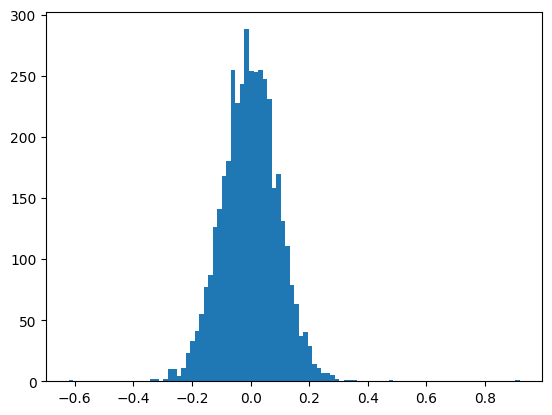

In [83]:
# Layer 15 SAE representation value counts
plt.hist(sparse_representation.flatten().data.type(torch.float32), bins=100);

## MMLU exploration
Let's use the `elementary_mathematics` as default

In [ ]:
mmlu_dataset = load_mmlu_dataset(config_name="elementary_mathematics")
print(mmlu_dataset)

In [5]:
def mmlu_data_prompt(dataset, example_idx, dataset_split):
    if not (dataset_split in ["test", "validation", "dev"]):
        raise ValueError("Invalid dataset split. Must be 'test', 'validation', or 'dev'.")

    example = dataset[dataset_split]
    question = example["question"][example_idx]
    subject = example["subject"][example_idx]
    choices = example["choices"][example_idx]
    answer = example["answer"][example_idx]

    prompt = f"Subject: {subject}\n\n"
    prompt += f"Question: {question}\n\n"
    prompt += "Choices:\n"

    letters = "ABCD"
    for i, choice in enumerate(choices):
        prompt += f"{letters[i]}. {choice}\n"

    # TODO room for reasoning. i.e. <think> <\think> block and final answer
    # prompt += "\nExplanations (finish by writing Answer: <your answer>)"

    # prompt += "\nAnswer:"

    prompt += "\nLet's solve this problem step by step:\n"


    return prompt

In [ ]:
prompt_demo_exmaple = mmlu_data_prompt(mmlu_dataset, 0, "test")
print(prompt_demo_exmaple)

E.g. using the Llama 3.1 8B base model

In [ ]:
input_text = mmlu_data_prompt(mmlu_dataset, 0, "test")
input_ids = llama_tokenizer(input_text, return_tensors="pt").to(llama_model.device)
output = llama_model.generate(**input_ids, max_new_tokens=32)
output_text = llama_tokenizer.decode(output[0])
print(output_text)

Let's try instead the R1 (8B distilled) reasoning model

In [ ]:
# Delete Llama model from GPU
try:
    del model
    del tokenizer
    del llama_model
    del llama_tokenizer
    torch.cuda.empty_cache()
except:
    pass

In [ ]:
tokenizer, model = load_r1_8B_model() # Loads to GPU as default

In [8]:
input_text = mmlu_data_prompt(mmlu_dataset, 0, "test")
input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)
output = model.generate(**input_ids, max_new_tokens=128)
output_text = tokenizer.decode(output[0])
print(output_text)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜>Subject: elementary_mathematics

Question: What is the value of p in 24 = 2p?

Choices:
A. p = 4
B. p = 8
C. p = 12
D. p = 24

Let's solve this problem step by step:
1. We have the equation 24 = 2p.
2. To find the value of p, we need to solve for p.
3. We can do this by dividing both sides of the equation by 2.
4. So, p = 24 / 2.
5. Calculating that gives p = 12.
6. Therefore, the correct answer is C. p = 12.

But wait, let me double-check. If p is 12, then 2 times 12 is indeed 24. So, yes, that makes sense.

Alternatively, thinking about it in another way: if I have 24 and I want to find out what number multiplied by 2 gives me 24, that number must be 12. So, p is 12.

I don't see any mistakes in this reasoning. It seems straightforward. So, the answer should definitely be C.
</think>

**Question:** What is the value of \( p \) in \( 24 = 2p \)?

**Choices:**
A. \( p = 4 \)
B. \( p = 8 \)
C. \( p = 12 \)
D. \( p = 24 \)

**Solution:**

To find the value of \( p \)

## Cleen-up

In [36]:
# # Free GPU memory
# del model  # remove the model instance
# torch.cuda.empty_cache()  # clear cached memory
# # gc.collect() # Necessary?